### **CARTPOLE DQN KERAS WITH PRIORITIZED REPLAY BUFFER**

The naive DQN version of CARTPOLE now is improved by adding a PRIORITY BUFFER CONFIGURATION <br>

This is a classical priority buffer with evaluation based on the TD calculation <br>

Different priority buffer configurations <br>
<br>
High priority (focuses more on important experiences) <br>
replay_buffer_high_priority = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.8, beta=0.6) <br>
<br>
Balanced priority (moderate prioritization) <br>
replay_buffer_balanced = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.6, beta=0.4) <br>
<br>
Low priority (closer to uniform sampling) <br>
replay_buffer_low_priority = PriorityReplayBuffer(MEMORY_SIZE, alpha=0.2, beta=0.1)<br>


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque, namedtuple
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

E0000 00:00:1749668007.401102 3966970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749668007.404488 3966970 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749668007.413825 3966970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749668007.413837 3966970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749668007.413838 3966970 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749668007.413839 3966970 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Hyperparameters**

In [3]:

MAX_EPISODES = 300
ROLLING_WINDOW = 20
MEMORY_SIZE = 2000
MAX_STEPS = 500

BETA = 0.6
ALPHA = 0.8

gamma = 0.95                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.98
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0                             # to see traces (verbosity)

seed_value = 37
np.random.seed(seed_value)

In [4]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


#### **Neural Network**

In [5]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(32, activation='relu', name="dense_1")(inputs)
    x = Dense(16, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
#    model.compile(optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0), loss='mse') # to improve train stability
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

DQN = build_model(state_size, action_size)
DQN.summary()

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722 (2.82 KB)

 Trainable params: 722 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Priority Replay Buffer Implementation
class PriorityReplayBuffer:
    def __init__(self, capacity, alpha=ALPHA, beta=BETA, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent (0 = uniform, 1 = full priority)
        self.beta = beta    # Importance sampling correction (0 = no correction, 1 = full correction)
        self.beta_increment = beta_increment
        self.max_priority = 1.0
        
        # Storage
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
        
        # Experience tuple
        self.Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
    
    def store(self, state, action, reward, next_state, done):
        """Store experience with maximum priority"""
        experience = self.Experience(state, action, reward, next_state, done)
        
        if self.size < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        
        # Assign maximum priority to new experience
        self.priorities[self.position] = self.max_priority
        
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample_experiences(self, batch_size):
        """Sample experiences based on priorities"""
        if self.size < batch_size:
            return None
        
        # Calculate sampling probabilities
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        
        # Sample indices based on probabilities
        indices = np.random.choice(self.size, batch_size, p=probabilities, replace=False)
        
        # Get experiences
        experiences = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        # Calculate importance sampling weights
        weights = (self.size * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        
        # Update beta for next sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards),
            np.vstack(next_states),
            np.array(dones, dtype=np.float32),
            indices,
            weights
        )
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for i, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + 1e-6) ** self.alpha  # Small epsilon to avoid zero priority
            self.priorities[i] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return self.size


#### **Support Functions**

In [7]:

def store(state, action, reward, next_state, done):             # memorize
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, DQN):                                      # act
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = DQN.predict(state, verbose=verb)
    return np.argmax(act_values[0])  # returns action selected with greedy strategy

    
def experience_replay(batch_size, model, epsilon):
    """Experience replay with priority sampling and importance sampling correction"""
    sample_result = replay_buffer.sample_experiences(batch_size)
    
    if sample_result is None:
        return
    
    states, actions, rewards, next_states, dones, indices, weights = sample_result
    
    # Predict Q-values for current and next states
    target_qs = model.predict(states, verbose=verb)
    next_qs = model.predict(next_states, verbose=verb)
    
    # Calculate TD targets
    td_targets = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
    # Calculate TD errors for priority updates
    td_errors = td_targets - target_qs[np.arange(batch_size), actions]
    
    # Update target Q-values
    target_qs[np.arange(batch_size), actions] = td_targets
    
    # Apply importance sampling weights to the loss
    sample_weights = np.ones(batch_size)  # Default weights
    if hasattr(model, 'sample_weight'):
        sample_weights = weights
    
    # Train the model
    model.fit(states, target_qs, sample_weight=sample_weights, epochs=1, verbose=0)
    
    # Update priorities in the buffer
    replay_buffer.update_priorities(indices, td_errors)


In [8]:
replay_buffer = PriorityReplayBuffer(MEMORY_SIZE)

rewards_per_episode= []

done = False
rolling_avg = 0
rolling_avg_rewards = []

start_time = time.time()

for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset(seed = seed_value)
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, DQN)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        replay_buffer.store(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        if replay_buffer.size > batch_size:
            experience_replay(batch_size, DQN, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3} Terminated: {done} ")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
        break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {testing_duration:.2f} minutes")

Episode:   1/300, Reward:  +12.00, Epsilon: 0.98, Rolling Avg:  12.00, Steps:  11 Terminated: True 
Episode:   2/300, Reward:  +40.00, Epsilon: 0.96, Rolling Avg:  26.00, Steps:  39 Terminated: True 
Episode:   3/300, Reward:  +32.00, Epsilon: 0.94, Rolling Avg:  28.00, Steps:  31 Terminated: True 
Episode:   4/300, Reward:  +28.00, Epsilon: 0.92, Rolling Avg:  28.00, Steps:  27 Terminated: True 
Episode:   5/300, Reward:  +15.00, Epsilon: 0.90, Rolling Avg:  25.40, Steps:  14 Terminated: True 
Episode:   6/300, Reward:  +24.00, Epsilon: 0.89, Rolling Avg:  25.17, Steps:  23 Terminated: True 
Episode:   7/300, Reward:  +12.00, Epsilon: 0.87, Rolling Avg:  23.29, Steps:  11 Terminated: True 
Episode:   8/300, Reward:  +50.00, Epsilon: 0.85, Rolling Avg:  26.62, Steps:  49 Terminated: True 
Episode:   9/300, Reward:  +48.00, Epsilon: 0.83, Rolling Avg:  29.00, Steps:  47 Terminated: True 
Episode:  10/300, Reward:  +20.00, Epsilon: 0.82, Rolling Avg:  28.10, Steps:  19 Terminated: True 


#### **Learning Plot and Episode Rewards**

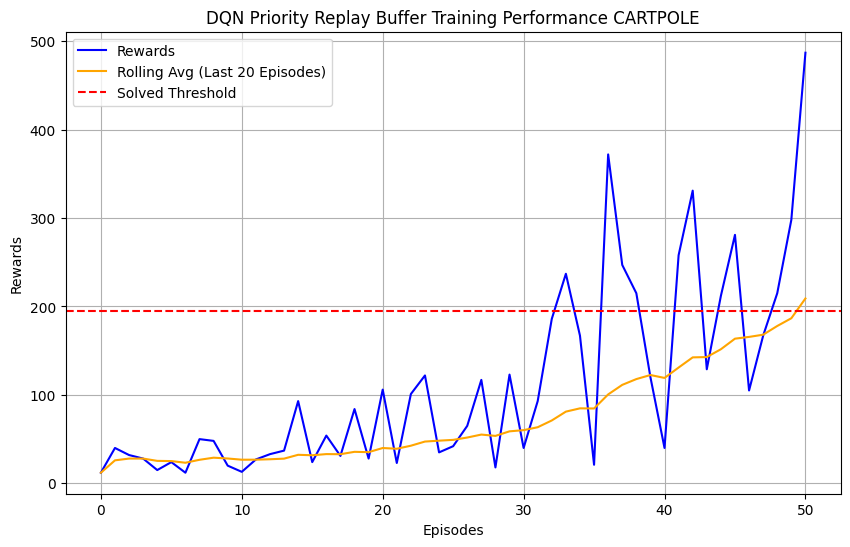

In [9]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Priority Replay Buffer Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [10]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 381.00, Steps: 381
Test Episode:  2/10, Reward: 306.00, Steps: 306
Test Episode:  3/10, Reward: 280.00, Steps: 280
Test Episode:  4/10, Reward: 235.00, Steps: 235
Test Episode:  5/10, Reward: 388.00, Steps: 388
Test Episode:  6/10, Reward: 276.00, Steps: 276
Test Episode:  7/10, Reward: 324.00, Steps: 324
Test Episode:  8/10, Reward: 259.00, Steps: 259
Test Episode:  9/10, Reward: 383.00, Steps: 383
Test Episode: 10/10, Reward: 479.00, Steps: 479
Testing completed in 2.41 minutes


#### **Rendering 1 episode**

In [13]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_PRB_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_PRB_DQN.gif')


Rendered Test Episode Reward: 449.00
Saved GIF to: ./CARTPOLE__PRB_DQN.gif


In [12]:
import session_info
session_info.show(html=False)

-----
PIL                 10.4.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.19.0
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
Linux-6.6.87.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-06-11 21:10
